Part 3 - History Dependence
===============================


    

**Exercise 1**

Using the toolbox history component on the spike train that you are modelling is easy. Either set the configuration option on a model you already have or use the shorthand RateAndHistoryModel to create a model:

    model = ni.model.RateModel(knots_rate=10)
    model.configuration.autohistory = True

    model = ni.model.RateAndHistoryModel(knots_rate=10,history_length=100,history_knots=4)


In [80]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import scipy as sp

cell = 2
condition = 0

# Load data for cell 2 in condition 0
data = np.load("data.npz")["spikes_outputencoding"][cell, condition, :, :]

N,T = data.shape

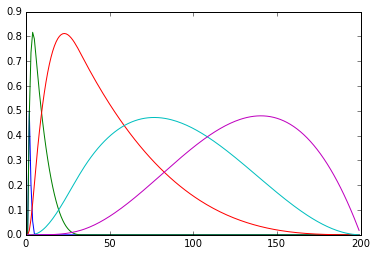

In [81]:
import splines
import statsmodels.api as sm

history_length = 200
num_knots = 4

# Create spline history kernel
history_spline_order = 3                                                      # solution
history_knots = splines.augknt(np.logspace(0,np.log(history_length),num_knots, base=np.exp(1)),history_spline_order)              # solution
history_knots = history_knots[:-1]
history_spline_bases = np.array(splines.spcol(np.arange(history_length),history_knots,history_spline_order))   # solution

plot(history_spline_bases);

(288000, 5)


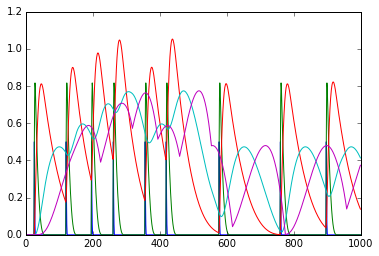

In [82]:
history_dm = np.zeros((N*T,num_knots+1))
spike_t = np.where(data.ravel())[0]
for t in spike_t:
    history_dm[t:t+history_length,:] += history_spline_bases[:min(t+history_length,N*T)-t,:]
print history_dm.shape

plot(history_dm[:1000])

(0, 14400)

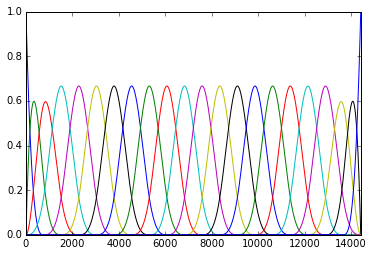

In [83]:
rate_spline_order = 3                                                      # solution
rate_knots = splines.augknt(np.linspace(0,T,20),rate_spline_order)              # solution
rate_spline_bases = np.array(splines.spcol(np.arange(T),rate_knots,rate_spline_order))   # solution
rate_dm = np.tile(rate_spline_bases,(N,1))                                      # solution

plot(rate_dm[:T])
xlim([0,T])

In [84]:
dm = np.hstack([history_dm, rate_dm])

#plot(dm[:T])
#xlim([0,T])

model = sm.GLM(data.ravel(),dm,family=sm.families.Binomial())      # solution
fitted_model = model.fit()                                            # solution
prediction = fitted_model.predict(dm[:T])                       # solution


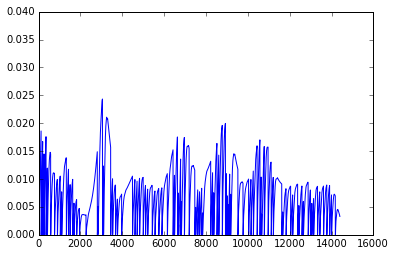

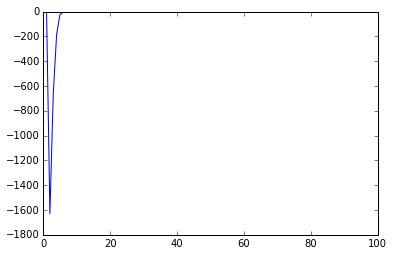

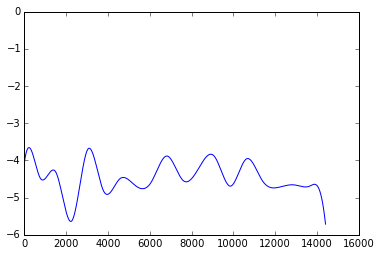

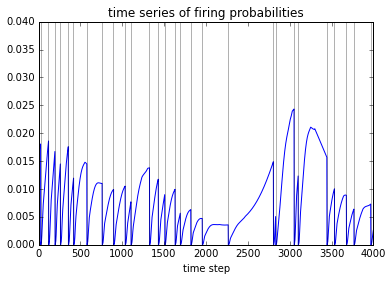

In [87]:
figure()
plot(prediction)
ylim([0,0.04])

figure()
plot(np.dot(history_spline_bases,fitted_model.params[:5]))
xlim([0,100])

figure()
plot(np.dot(rate_spline_bases,fitted_model.params[5:]))

figure()
spike_t = np.where(data[0])[0].reshape((1,-1)).repeat(2,axis=0)
spike_y = np.zeros((2,len(spike_t))) + np.array([[0],[0.4]])

plot(prediction)
plot(spike_t,spike_y,"k-", alpha=0.3)
xlim([0,4000])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')


--got until here --
----------------------

In [1]:
import ni

cell = 0
data = ni.Data('data/output_encoding.pkl').cell(cell).condition(0).time(4000,8000).reduce_resolution(1)
print data

random_trials = random.permutation(range(data.nr_trials))
training_data = data.trial(random_trials[:data.nr_trials/2])
test_data = data.trial(random_trials[data.nr_trials/2:])

Spike data: 1 Condition(s) 20 Trial(s) of 1 Cell(s) in 4000 Time step(s).


This code will fit a range of models on the same data. Do cross-validation and vary either **knots_rates** or the number of **history_knots** or the **history_length** parameter.

<h3 style='color:darkred;'>This Cell will take a long time to evaluate.</h3>

Some small values of history length, or too many basis functions can cause the model to need very long to converge.
If you want to stop the execution, go to Kernel->Interrupt.

You can decrease the amount of data your computer has to deal with by either taking a smaller time frame (default is 4000ms-8000ms out of 14s), or use `.reduce_resolution(2)` to merge every two bins into one (this will increase the firing rate).

 20 30 40

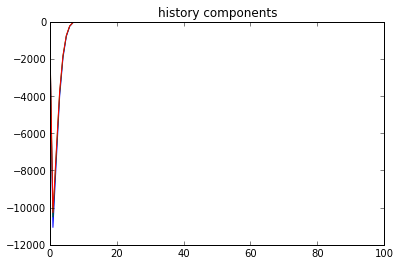

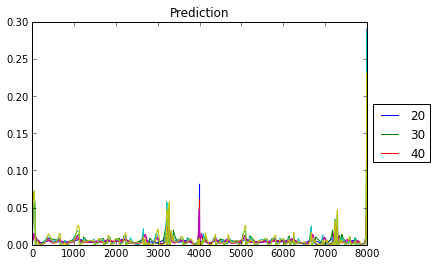

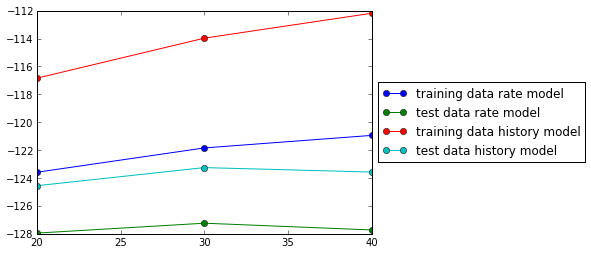

In [12]:
knots_rate_list = [20,30,40] #solution


likelihoods = np.zeros((len(knots_rate_list),4))
likelihoods_train = []
likelihoods_test = []
# We want two plots to be updated for each model
# one for the fitted history component:
history_plot = ni.figure('',display=False,close=False)
# and one for the complete prediciton
predictions_plot = ni.figure('',display=False,close=False)

for (i,knots_rate) in enumerate(knots_rate_list):
    print knots_rate,
    rate_model = ni.model.RateModel(knots_rate=knots_rate) # solution
    fitted_rate_model = rate_model.fit(training_data)
    history_model = ni.model.RateAndHistoryModel(knots_rate=knots_rate,history_length=100,history_knots=5) # solution
    fitted_history_model = history_model.fit(training_data)
    prototypes = fitted_history_model.prototypes()
    # here we add new lines to each of the two plots
    with history_plot:
        plot(prototypes['autohistory'],label='autohistory')
    with predictions_plot:
        plot(fitted_rate_model.predict(data.trial([0,3])))
        plot(fitted_history_model.predict(data.trial([0,3])))
    likelihoods[i,0] = fitted_rate_model.compare(training_data)['LogLikelihood']
    likelihoods[i,1] = fitted_rate_model.compare(test_data)['LogLikelihood']  
    likelihoods[i,2] = fitted_history_model.compare(training_data)['LogLikelihood']
    likelihoods[i,3] = fitted_history_model.compare(test_data)['LogLikelihood']

with history_plot:
    title('history components')
with predictions_plot:
    title('Prediction')
    legend(knots_rate_list,loc='center left', bbox_to_anchor=(1, 0.5))
history_plot.show()     # this closes the plots and displays them in the notebook
predictions_plot.show() # (this is only necessary if we have multiple plots)

# The next plot will compare the likelihoods
plot(knots_rate_list,likelihoods,'-o')
legend(['training data rate model','test data rate model','training data history model','test data history model'],loc='center left', bbox_to_anchor=(1, 0.5))

**iPython notebook tip**
If you want to keep a code cell and its output after you executed it, but also want to try another variant of the same code, you can copy a cell under Edit->Copy Cell/Edit->Paste Cell Below (or Ctrl+[m], [c], Ctrl+[m], [b], then Ctrl+[m], [v]) or you can use the next cell to insert the code of the most recently executed cell:

In [2]:
get_ipython().set_next_input(_i)

Regularization
-------------------

**Exercise 2**

Now try the same code with a backend that uses regularization. Set the backend of the model to 'elasticnet' somewhere before fitting:

    model.backend = 'elasticnet'

How did this change the estimated parameters and prediction? What about the likelihood curves?

20 30 40

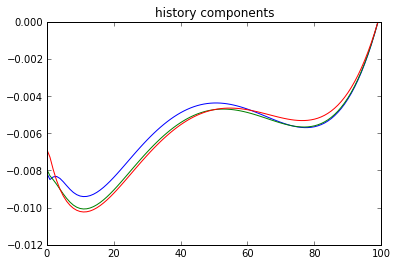

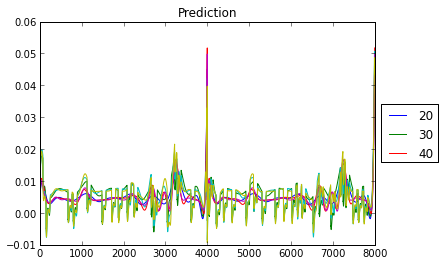

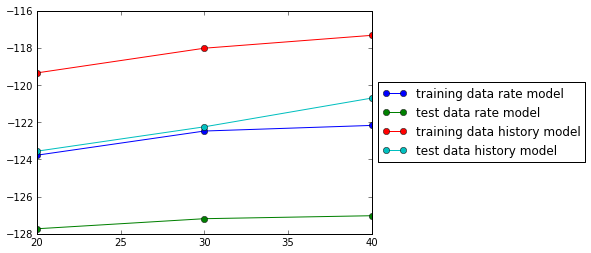

In [13]:
knots_rate_list = [20,30,40] #solution


likelihoods = np.zeros((len(knots_rate_list),4))
likelihoods_train = []
likelihoods_test = []
# We want two plots to be updated for each model
# one for the fitted history component:
history_plot = ni.figure('',display=False,close=False)
# and one for the complete prediciton
predictions_plot = ni.figure('',display=False,close=False)

for (i,knots_rate) in enumerate(knots_rate_list):
    print knots_rate,
    rate_model = ni.model.RateModel(knots_rate=knots_rate) # solution
    rate_model.backend = 'elasticnet'
    fitted_rate_model = rate_model.fit(training_data)
    history_model = ni.model.RateAndHistoryModel(knots_rate=knots_rate,history_length=100,history_knots=5) # solution
    history_model.backend = 'elasticnet'
    fitted_history_model = history_model.fit(training_data)
    prototypes = fitted_history_model.prototypes()
    # here we add new lines to each of the two plots
    with history_plot:
        plot(prototypes['autohistory'],label='autohistory')
    with predictions_plot:
        plot(fitted_rate_model.predict(data.trial([0,3])))
        plot(fitted_history_model.predict(data.trial([0,3])))
    likelihoods[i,0] = fitted_rate_model.compare(training_data)['LogLikelihood']
    likelihoods[i,1] = fitted_rate_model.compare(test_data)['LogLikelihood']  
    likelihoods[i,2] = fitted_history_model.compare(training_data)['LogLikelihood']
    likelihoods[i,3] = fitted_history_model.compare(test_data)['LogLikelihood']

with history_plot:
    title('history components')
with predictions_plot:
    title('Prediction')
    legend(knots_rate_list,loc='center left', bbox_to_anchor=(1, 0.5))
history_plot.show()     # this closes the plots and displays them in the notebook
predictions_plot.show() # (this is only necessary if we have multiple plots)

# The next plot will compare the likelihoods
plot(knots_rate_list,likelihoods,'-o')
legend(['training data rate model','test data rate model','training data history model','test data history model'],loc='center left', bbox_to_anchor=(1, 0.5))

Crosshistory
--------------

**Exercise 3**

If you want to include more information in your model, you can use the data from other cells as well.

In [1]:
import ni
data = ni.Data('data/output_encoding.pkl').condition(0)
print data

Spike data: 1 Condition(s) 20 Trial(s) of 20 Cell(s) in 14400 Time step(s).


This object contains spike trains from 20 cells. If you use .condition() or .trial() on the object, it will act on all cells simulataneously, such that you get the same trial for all cells.

In [2]:
print data.trial([1,2,3])

Spike data: 1 Condition(s) 3 Trial(s) of 20 Cell(s) in 14400 Time step(s).


If there is more than one cell in the data, the Model objects can be told which of the cells are the dependent and which are the independent variables. The default `ip.Model` will assume cell 0 to be the dependent cell and create crosshistory terms for all other cells in the data object. Change the `cell` attribute in the configuration to model a different cell:

In [8]:
model = ni.model.ip.Model()
model.configuration.cell = 3

fm = model.fit(data.time(4000,6000))

This will create crosshistory terms for cells 0,1,2,4,5,..19. The option `crosshistory` determines what cells are included in the model.

If `crosshistory == True`, all cells are included (except the dependent one), for `False` no cells are used. If `crosshistory` is set to a list of integers, only the corresponding cells are used:

    model.configuration.crosshistory = [5,6]

**Exercise 3 a)**

Now, create a model that predicts cell 5 using cells 1...4, but that uses no rate component!

<a href="http://jahuth.github.io/ni/ni.model.html#ni.model.ip.Configuration">Here</a> is a link to the documentation, telling you what options are available.

In [2]:
model = ni.model.ip.Model()
model.configuration.cell = 5                         # solution
model.configuration.crosshistory = [1,2,3,4]         # solution
model.configuration.history_length = 100             # solution
model.configuration.rate = False                     # solution

fitted_model = model.fit(data.trial(range(data.nr_trials/2)))

 Either set configuration options when creating the model (with `Model({`*'option':value*`})`) or afterwards, using `model.configuration.`*option*`= value`

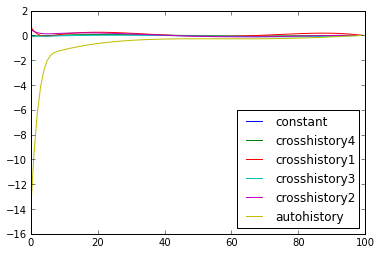

In [14]:
prototypes = fitted_model.prototypes()
for p in prototypes:
    plot(prototypes[p])
legend(prototypes.keys(), loc=4)

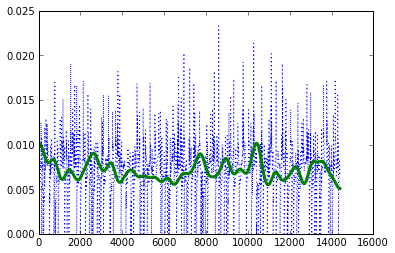

In [15]:
plot(fitted_model.predict(data.trial(0)),':')
plot(data.cell(5).firing_rate(200),lw=3)

That's it for Part 3!
==========================